<a href="https://colab.research.google.com/github/Tanishtha-Reddy/Plantify-Disease-Detection-for-Crops/blob/main/Plantify_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING DATASET FROM KAGGLE

In [10]:
from google.colab import userdata
import os



!mkdir -p ~/.kaggle
!echo '{"username":"'$KAGGLE_USERNAME'","key":"'$KAGGLE_KEY'"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list | head -n 5

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                         468320  2026-01-04 14:23:35.490000          10051        161  1.0              
rockyt07/social-media-user-analysis                             Social Media User Analysis                           247842357  2026-01-14 02:28:41.970000           6271        133  1.0              
vishardmehta/indian-engineering-college-placement-dataset       Indian Engineering College Placement Dataset            137603  2026-01-24 15:23:40.150000           1494         42  1.0              


In [11]:
from google.colab import files
files.upload()  # upload kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ksaitanishthareddy","key":"77015b6d956c9e2a553fba82ade0e54a"}'}

In [5]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

UNZIPPING AND ORGANIZING DATASET

In [6]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip -q new-plant-diseases-dataset.zip -d /content/plant_data

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:27<00:00, 107MB/s] 
100% 2.70G/2.70G [00:27<00:00, 105MB/s]


In [7]:
!ls /content/plant_data
!ls "/content/plant_data/New Plant Diseases Dataset(Augmented)"
!ls "/content/plant_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

'new plant diseases dataset(augmented)'   test
'New Plant Diseases Dataset(Augmented)'
'New Plant Diseases Dataset(Augmented)'
train  valid


USING PYTORCH & GETTING DATA READY

In [8]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_folder = "/content/plant_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_folder = "/content/plant_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [14]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
valid_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
train_dataset = ImageFolder(train_folder, transform=train_transform)
valid_dataset = ImageFolder(valid_folder, transform=valid_transform)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [18]:
print(f"Classes found: {len(train_dataset.classes)}")
print("Example classes:", train_dataset.classes[:5])
print(f"Train images: {len(train_dataset)}")
print(f"Valid images: {len(valid_dataset)}")

Classes found: 38
Example classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
Train images: 70295
Valid images: 17572


IMPLEMENTING MobileNetV2

In [19]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [20]:
#Load pre-trained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
# MobileNetV2 has classifier as Sequential with Linear layers
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 38))

In [23]:
model = model.to(device)
print("Model loaded and moved to", device)

Model loaded and moved to cpu


In [24]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [25]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [26]:
#Training loop
num_epochs = 3
best_val_acc = 0.0

In [ ]:
print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/plantify_mobilenetv2_best.pth")
        print("New best model saved!")

scheduler.step()

print(f"Training done! Best validation accuracy: {best_val_acc:.2f}%")

Epoch 10: Train Loss: 0.1368 | Train Acc: 95.40% | Val Loss: 0.0914 | Val Acc: 97.05%
Training done! Best validation accuracy: 97.05%


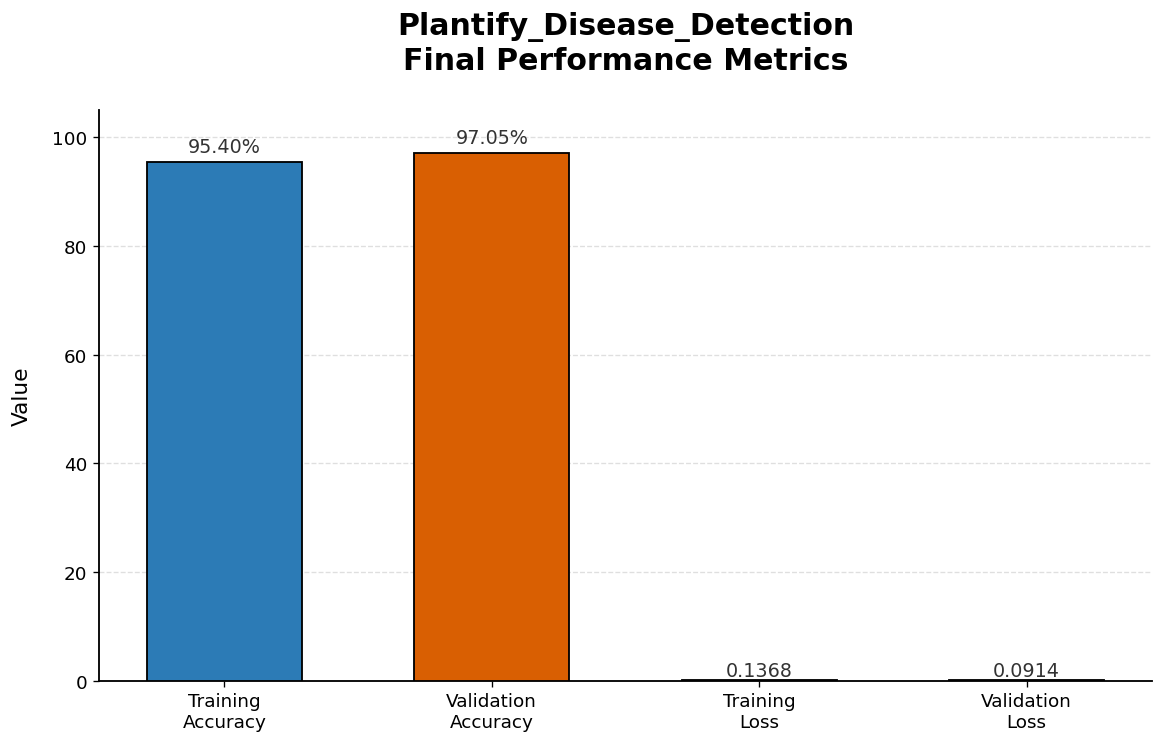

Professional chart saved as:
/content/plantify_final_metrics_professional.png
Download it from the Files tab (left sidebar) → right-click → Download


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Final metrics from your training run

metrics = ['Training\nAccuracy', 'Validation\nAccuracy', 'Training\nLoss', 'Validation\nLoss']
values   = [95.40, 97.05, 0.1368, 0.0914]

# Colors: professional blue/orange contrast (inspired by matplotlib default but refined)
colors = ['#2c7bb6', '#d95f02', '#2c7bb6', '#d95f02']


# Create figure
fig, ax = plt.subplots(figsize=(10, 6.5), dpi=120)

# Bars
bars = ax.bar(metrics, values, color=colors, width=0.58,
              edgecolor='black', linewidth=1.1, zorder=3)


# Styling & annotations
ax.set_title('Plantify_Disease_Detection\nFinal Performance Metrics',
             fontsize=18, fontweight='bold', pad=25)

ax.set_ylabel('Value', fontsize=13, labelpad=12)

# Dynamic y-limit to give headroom for labels
max_val = max(values)
ylim_max = 105 if max_val > 1 else max_val * 1.35
ax.set_ylim(0, ylim_max)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    label = f'{height:.2f}%' if height > 1 else f'{height:.4f}'
    va_pos = 'bottom' if height > 0 else 'top'
    offset = 1.2 if height > 1 else 0.008
    ax.text(bar.get_x() + bar.get_width()/2, height + offset,
            label, ha='center', va=va_pos,
            fontsize=11.5, fontweight='medium', color='#333333')

# Grid & spines
ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)

ax.tick_params(axis='both', which='major', labelsize=11)


# Final layout & save
plt.tight_layout(pad=1.8)
plt.show()

# Save high-quality version for presentation / README
save_path = '/content/plantify_final_metrics_professional.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Professional chart saved as:\n{save_path}")
print("Download it from the Files tab (left sidebar) → right-click → Download")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/MyDrive/Plantify_Disease_Detection"
!mkdir -p "{project_dir}"

# Save model
!cp "/content/plantify_mobilenetv2_best.pth" "{project_dir}/plantify_best.pth"

# Save plot
!cp "/content/plantify_curves_manual.png" "{project_dir}/training_curves.png"

# Save class names
import json
with open(f"{project_dir}/class_names.json", "w") as f:
    json.dump(train_dataset.classes, f)

print("Project files saved in Google Drive → Plantify_Disease_Detection folder")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/plantify_curves_manual.png': No such file or directory
Project files saved in Google Drive → Plantify_Disease_Detection folder


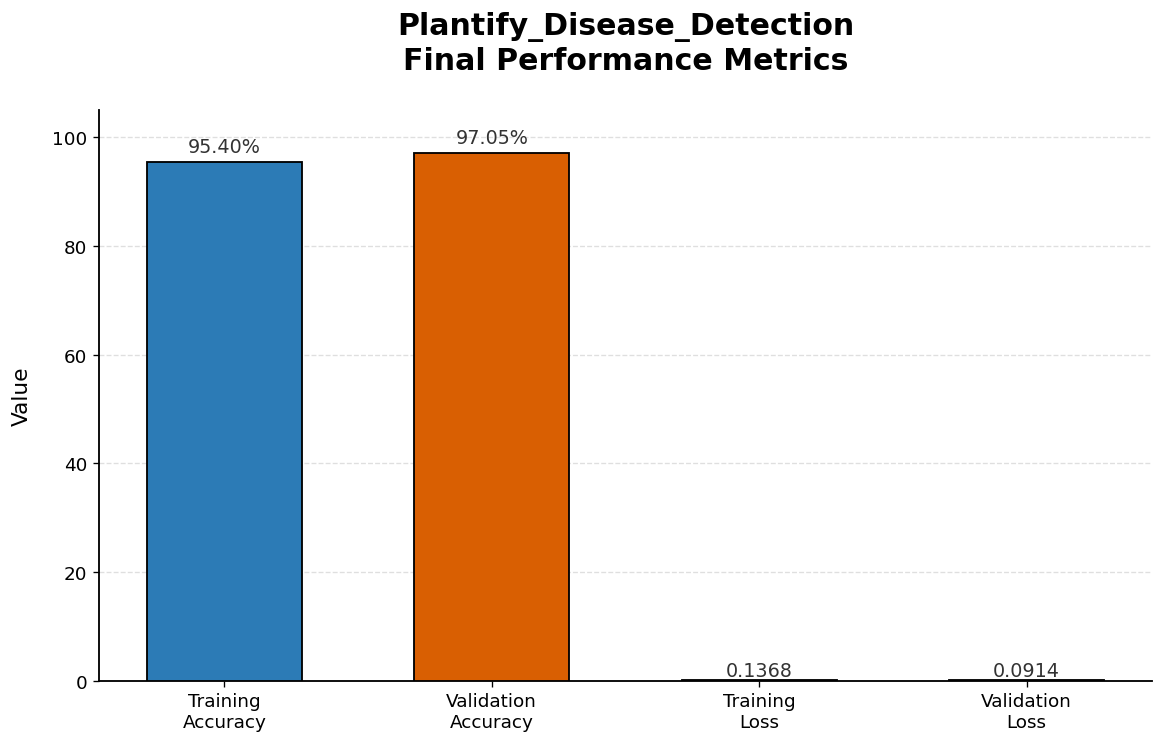

Plot saved in Colab: /content/plantify_final_metrics_professional.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Training\nAccuracy', 'Validation\nAccuracy', 'Training\nLoss', 'Validation\nLoss']
values  = [95.40, 97.05, 0.1368, 0.0914]
colors  = ['#2c7bb6', '#d95f02', '#2c7bb6', '#d95f02']

fig, ax = plt.subplots(figsize=(10, 6.5), dpi=120)
bars = ax.bar(metrics, values, color=colors, width=0.58,
              edgecolor='black', linewidth=1.1, zorder=3)

ax.set_title('Plantify_Disease_Detection\nFinal Performance Metrics',
             fontsize=18, fontweight='bold', pad=25)
ax.set_ylabel('Value', fontsize=13, labelpad=12)

max_val = max(values)
ylim_max = 105 if max_val > 1 else max_val * 1.35
ax.set_ylim(0, ylim_max)

for bar in bars:
    height = bar.get_height()
    label = f'{height:.2f}%' if height > 1 else f'{height:.4f}'
    va_pos = 'bottom' if height > 0 else 'top'
    offset = 1.2 if height > 1 else 0.008
    ax.text(bar.get_x() + bar.get_width()/2, height + offset,
            label, ha='center', va=va_pos,
            fontsize=11.5, fontweight='medium', color='#333333')

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)
ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout(pad=1.8)
plt.show()

# Save it right here
plt.savefig('/content/plantify_final_metrics_professional.png', dpi=300, bbox_inches='tight', facecolor='white')
print("Plot saved in Colab: /content/plantify_final_metrics_professional.png")

In [ ]:
from google.colab import drive

# Mount
drive.mount('/content/drive', force_remount=False)

project_dir = "/content/drive/MyDrive/Plantify_Disease_Detection"
!mkdir -p "{project_dir}"

# Copy model
!cp "/content/plantify_mobilenetv2_best.pth" "{project_dir}/plantify_best.pth" 2>/dev/null || echo "Model file not found — skip if already saved"


!cp "/content/plantify_final_metrics_professional.png" "{project_dir}/final_metrics_chart.png"

# Save class names
import json
class_names_path = f"{project_dir}/class_names.json"
with open(class_names_path, "w") as f:
    json.dump(train_dataset.classes, f)

print("\nAll files saved in Google Drive folder:")
print( project_dir)
print("Files inside:")
!ls -l "{project_dir}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

All files saved in Google Drive folder:
/content/drive/MyDrive/Plantify_Disease_Detection
Files inside:
total 9139
-rw------- 1 root root    1098 Jan 30 19:44 class_names.json
-rw------- 1 root root   15128 Jan 30 19:44 final_metrics_chart.png
-rw------- 1 root root 9340683 Jan 30 19:44 plantify_best.pth


In [ ]:
# Save with CPU mapping (recommended for hackathon portability)
torch.save(model.cpu().state_dict(), "/content/plantify_best_cpu.pth")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import json

# Paths
MODEL_PATH   = "/content/drive/MyDrive/Plantify_Disease_Detection/plantify_best.pth"
CLASSES_PATH = "/content/drive/MyDrive/Plantify_Disease_Detection/class_names.json"

# Load classes
with open(CLASSES_PATH, 'r') as f:
    class_names = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Rebuild model structure
model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, len(class_names))
)

# Load weights safely
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print("Model ready!")

Device: cuda
Model ready!


In [ ]:
# 1. Mount Google Drive (run this first if not already mounted)

from google.colab import drive
drive.mount('/content/drive', force_remount=False)


# 2. Imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import json
from IPython.display import display

# 3. Paths to your saved files

MODEL_PATH   = "/content/drive/MyDrive/Plantify_Disease_Detection/plantify_best.pth"
CLASSES_PATH = "/content/drive/MyDrive/Plantify_Disease_Detection/class_names.json"


# 4. Load class names

with open(CLASSES_PATH, 'r') as f:
    class_names = json.load(f)

print(f"Loaded {len(class_names)} classes successfully.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, len(class_names))
)

# Load weights safely (works on CPU or GPU)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully!")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


remedies = {
    'Apple___Apple_scab': 'Remove infected leaves immediately. Apply copper-based or myclobutanil fungicide. Improve air circulation and avoid overhead watering.',
    'Apple___Black_rot': 'Prune and destroy infected branches and mummified fruit. Apply captan or thiophanate-methyl fungicide. Remove debris.',
    'Apple___Cedar_apple_rust': 'Remove nearby cedar/juniper trees (alternate host). Apply preventive fungicides (e.g., myclobutanil) in early spring.',
    'Apple___healthy': 'Plant is healthy. Maintain good cultural practices: proper spacing, watering, and fertilization.',
    'Blueberry___healthy': 'Plant is healthy. Continue monitoring for pests/diseases.',
    'Cherry_(including_sour)___Powdery_mildew': 'Apply sulfur-based fungicides or potassium bicarbonate. Prune for better airflow. Avoid excessive nitrogen.',
    'Cherry___healthy': 'Plant is healthy. No action needed.',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'Use crop rotation. Plant resistant hybrids. Apply strobilurin fungicides if severe.',
    'Corn_(maize)___Common_rust_': 'Plant resistant varieties. Apply azoxystrobin or propiconazole if needed. Reduce humidity around plants.',
    'Corn_(maize)___Northern_Leaf_Blight': 'Crop rotation (2–3 years). Avoid overhead irrigation. Use resistant hybrids.',
    'Corn_(maize)___healthy': 'Plant is healthy.',
    'Grape___Black_rot': 'Remove mummified fruit and canes. Apply mancozeb or captan fungicide. Improve canopy ventilation.',
    'Grape___Esca_(Black_Measles)': 'No curative treatment. Prune and remove infected wood. Use wound protectants on pruning cuts.',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'Apply mancozeb or copper fungicides. Prune for air circulation. Avoid wet foliage.',
    'Grape___healthy': 'Plant is healthy.',
    'Orange___Haunglongbing_(Citrus_greening)': 'No cure. Remove and destroy infected trees. Control Asian citrus psyllid vector with insecticides.',
    'Peach___Bacterial_spot': 'Apply copper-based sprays during dormancy and bloom. Remove infected twigs. Avoid overhead watering.',
    'Peach___healthy': 'Plant is healthy.',
    'Pepper,_bell___Bacterial_spot': 'Use copper sprays preventively. Remove infected leaves. Practice crop rotation.',
    'Pepper,_bell___healthy': 'Plant is healthy.',
    'Potato___Early_blight': 'Mulch to reduce soil splash. Apply chlorothalonil or mancozeb. Rotate crops.',
    'Potato___Late_blight': 'Destroy infected plants immediately. Use metalaxyl or mandipropamid preventively. Avoid wet conditions.',
    'Potato___healthy': 'Plant is healthy.',
    'Raspberry___healthy': 'Plant is healthy.',
    'Soybean___healthy': 'Plant is healthy.',
    'Squash___Powdery_mildew': 'Apply sulfur or potassium bicarbonate sprays. Improve airflow by spacing plants properly.',
    'Strawberry___Leaf_scorch': 'Remove infected leaves. Improve soil drainage and avoid overhead watering.',
    'Strawberry___healthy': 'Plant is healthy.',
    'Tomato___Bacterial_spot': 'Apply copper-based bactericides. Remove infected parts. Avoid overhead watering.',
    'Tomato___Early_blight': 'Mulch, stake plants for airflow. Apply chlorothalonil or copper fungicide.',
    'Tomato___Late_blight': 'Remove and destroy infected plants. Use preventive fungicides (e.g., mancozeb + metalaxyl).',
    'Tomato___Leaf_Mold': 'Improve greenhouse ventilation. Use resistant varieties. Apply fungicides if needed.',
    'Tomato___Septoria_leaf_spot': 'Remove lower infected leaves. Apply chlorothalonil or mancozeb. Rotate crops.',
    'Tomato___Spider_mites Two-spotted_spider_mite': 'Use miticides (abamectin) or insecticidal soap. Increase humidity. Release predatory mites.',
    'Tomato___Target_Spot': 'Crop rotation. Apply azoxystrobin or chlorothalonil. Avoid overhead irrigation.',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 'Control whitefly vector with insecticides. Use resistant varieties. Remove infected plants.',
    'Tomato___Tomato_mosaic_virus': 'No cure. Remove and destroy infected plants. Use certified virus-free seed.',
    'Tomato___healthy': 'Plant is healthy. Continue good practices.'
}

print("Remedies dictionary ready (38 classes).")


def predict_leaf(image_path):
    try:
        # Display the image for visual confirmation
        print("\nUploaded image:")
        display(Image(filename=image_path, width=400))

        img = Image.open(image_path).convert('RGB')
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_t)
            probs = torch.softmax(output, dim=1)[0]
            pred_idx = torch.argmax(probs).item()
            confidence = probs[pred_idx].item() * 100

        disease = class_names[pred_idx]
        remedy = remedies.get(disease, "Consult a local agricultural expert or extension service for tailored advice.")

        print("\n" + "═" * 60)
        print(f"  PLANTIFY DISEASE DETECTION")
        print(f"  Image: {image_path.split('/')[-1]}")
        print(f"  Predicted: {disease}")
        print(f"  Confidence: {confidence:.2f}%")
        print(f"  Recommendation: {remedy}")
        print("═" * 60 + "\n")

        return disease, confidence, remedy

    except Exception as e:
        print(f"Error: {str(e)}")
        return None, 0, f"Error: {str(e)}"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 38 classes successfully.
Using device: cuda
Model loaded successfully!
Remedies dictionary ready (38 classes).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image as PILImage   # ← use different name to avoid conflict
import json
from IPython.display import display, Image as DisplayImage

# Paths
MODEL_PATH   = "/content/drive/MyDrive/Plantify_Disease_Detection/plantify_best.pth"
CLASSES_PATH = "/content/drive/MyDrive/Plantify_Disease_Detection/class_names.json"

with open(CLASSES_PATH, 'r') as f:
    class_names = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, len(class_names))
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded OK")

Device: cuda
Model loaded OK


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

remedies = {
    'Apple___Apple_scab': 'Remove infected leaves. Apply copper-based fungicide. Improve air circulation.',
    'Apple___Black_rot': 'Prune dead branches. Use fungicides like captan. Remove mummified fruit.',
    'Apple___Cedar_apple_rust': 'Remove nearby cedar trees if possible. Apply preventive fungicides in spring.',
    'Apple___healthy': 'Plant is healthy. Continue monitoring.',
    'Blueberry___healthy': 'Plant is healthy.',
    'Cherry_(including_sour)___Powdery_mildew': 'Apply sulfur-based fungicides or potassium bicarbonate. Prune for better airflow.',
    'Cherry___healthy': 'Plant is healthy.',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'Crop rotation. Plant resistant hybrids. Apply strobilurin fungicides if severe.',
    'Corn_(maize)___Common_rust_': 'Plant resistant varieties. Apply azoxystrobin or propiconazole if needed.',
    'Corn_(maize)___Northern_Leaf_Blight': 'Crop rotation. Avoid overhead irrigation. Use resistant hybrids.',
    'Corn_(maize)___healthy': 'Plant is healthy.',
    'Grape___Black_rot': 'Remove mummified fruit and canes. Apply mancozeb or captan fungicide.',
    'Grape___Esca_(Black_Measles)': 'No curative treatment. Prune infected wood. Use wound protectants.',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'Apply mancozeb or copper fungicides. Prune for air circulation.',
    'Grape___healthy': 'Plant is healthy.',
    'Orange___Haunglongbing_(Citrus_greening)': 'No cure. Remove infected trees. Control psyllid vector.',
    'Peach___Bacterial_spot': 'Apply copper sprays. Remove infected twigs.',
    'Peach___healthy': 'Plant is healthy.',
    'Pepper,_bell___Bacterial_spot': 'Use copper sprays. Remove infected leaves. Crop rotation.',
    'Pepper,_bell___healthy': 'Plant is healthy.',
    'Potato___Early_blight': 'Mulch to reduce soil splash. Apply chlorothalonil or mancozeb.',
    'Potato___Late_blight': 'Destroy infected plants. Use metalaxyl or mandipropamid preventively.',
    'Potato___healthy': 'Plant is healthy.',
    'Raspberry___healthy': 'Plant is healthy.',
    'Soybean___healthy': 'Plant is healthy.',
    'Squash___Powdery_mildew': 'Apply sulfur or potassium bicarbonate sprays. Improve airflow.',
    'Strawberry___Leaf_scorch': 'Remove infected leaves. Improve drainage.',
    'Strawberry___healthy': 'Plant is healthy.',
    'Tomato___Bacterial_spot': 'Apply copper-based bactericides. Remove infected parts.',
    'Tomato___Early_blight': 'Mulch, stake plants. Apply chlorothalonil or copper fungicide.',
    'Tomato___Late_blight': 'Remove infected plants. Use preventive fungicides.',
    'Tomato___Leaf_Mold': 'Improve ventilation. Use resistant varieties.',
    'Tomato___Septoria_leaf_spot': 'Remove lower leaves. Apply chlorothalonil or mancozeb.',
    'Tomato___Spider_mites Two-spotted_spider_mite': 'Use miticides or insecticidal soap. Increase humidity.',
    'Tomato___Target_Spot': 'Crop rotation. Apply azoxystrobin or chlorothalonil.',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 'Control whiteflies. Use resistant varieties.',
    'Tomato___Tomato_mosaic_virus': 'Remove infected plants. Use certified seed.',
    'Tomato___healthy': 'Plant is healthy.'
}

def predict_leaf(image_path):
    try:
        # Show the image
        print("\nUploaded image:")
        display(DisplayImage(filename=image_path, width=400))

        img = PILImage.open(image_path).convert('RGB')
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_t)
            probs = torch.softmax(output, dim=1)[0]
            pred_idx = torch.argmax(probs).item()
            confidence = probs[pred_idx].item() * 100

        disease = class_names[pred_idx]
        remedy = remedies.get(disease, "Consult local expert for remedy.")

        print("\n" + "═" * 60)
        print(f"  PLANTIFY PREDICTION")
        print(f"  Image: {image_path.split('/')[-1]}")
        print(f"  → {disease}")
        print(f"  Confidence: {confidence:.2f}%")
        print(f"  Recommendation: {remedy}")
        print("═" * 60 + "\n")

    except Exception as e:
        print("Error:", str(e))

print("Ready. Now run the prediction cell below.")

NameError: name 'transforms' is not defined


Uploaded image:


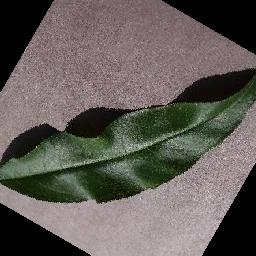


════════════════════════════════════════════════════════════
  PLANTIFY PREDICTION
  Image: trial_leaf.jpg
  → Peach___healthy
  Confidence: 100.00%
  Recommendation: Plant is healthy.
════════════════════════════════════════════════════════════



In [ ]:

predict_leaf("/content/trial_leaf.jpg")


Uploaded image:


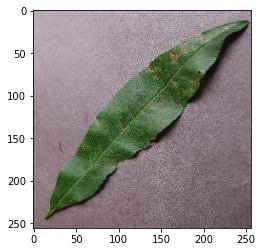


════════════════════════════════════════════════════════════
  PLANTIFY PREDICTION
  Image: trial_leaf2.jpg
  → Peach___Bacterial_spot
  Confidence: 63.84%
  Recommendation: Apply copper sprays. Remove infected twigs.
════════════════════════════════════════════════════════════



In [ ]:
predict_leaf("/content/trial_leaf2.jpg")